In [1]:
!pip install fastai==2.2.5 -Uqq
!pip install fastcore -Uqq
!pip install nbdev -Uqq

In [2]:
from fastai.tabular.all import *
from fastcore.utils import *
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## Neural Net

I use a simple dataset from Kaggle's March Tabular Playground Series. Download these data [here](https://www.kaggle.com/c/tabular-playground-series-mar-2021/data).

In [ ]:
# !unzip '/content/train.csv'
# !unzip '/content/test.csv'

In [5]:
df_nn = pd.read_csv('/content/train.csv', low_memory=False)
df_nn_final = df_nn.drop('id', axis=1)

In [6]:
cont,cat = cont_cat_split(df_nn_final, max_card=9000, dep_var='target')
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(seed=23)(df_nn_final)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

to_nn = TabularPandas(df_nn, procs_nn, cat, cont,
                      splits=splits, y_names='target')
dls = to_nn.dataloaders(1024, device = device)

In [7]:
learn = tabular_learner(dls, layers=[500,250], n_out=1)
learn.fit_one_cycle(8, 5e-4)

epoch,train_loss,valid_loss,time
0,0.120530,0.117045,00:05
1,0.115052,0.114975,00:05
2,0.110268,0.111879,00:05
3,0.106003,0.111814,00:05
4,0.103692,0.111779,00:05
5,0.099670,0.111492,00:05
6,0.095625,0.111328,00:05
7,0.094228,0.111272,00:05


In [8]:
preds,targs = learn.get_preds()
roc_auc_score(targs, preds)

0.8820512252460494

In [9]:
learn.save('learn8')

Path('models/learn8.pth')

## Machine Learning Models

In [10]:
df = pd.read_csv('/content/train.csv', low_memory=False)

In [11]:
# using the neural net's `cat`, `cont`, and `splits`
procs = [Categorify]
to = TabularPandas(df, procs, cat, cont, 'target', splits = splits)

In [12]:
def rf(xs, y, n_estimators=40, max_samples=130_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf).fit(xs, y)

In [13]:
def auc(m, xs, y):
  preds = m.predict(xs)
  return round(roc_auc_score(y, preds), 3)

## Replacing Nominal Variables with Embeddings

In [15]:
learn = learn.load('/content/models/learn8')

In [19]:
def embed_features(learner, xs):
  """
  learner: fastai Learner used to train the neural net
  xs: DataFrame containing input variables with nominal values defined by their rank.
  ::returns:: a copy of `xs` with embeddings replacing each categorical variable
  """
  xs = xs.copy()
  for i,col in enumerate(learn.dls.cat_names):
    emb = learn.model.embeds[i]
    emb_data = emb(tensor(xs[col], dtype=torch.int64).to(device))
    emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]
    feat_df = pd.DataFrame(data=emb_data, index=xs.index, columns=emb_names)
    xs = xs.drop(col, axis=1)
    xs = xs.join(feat_df)
  return xs

In [20]:
emb_xs = embed_features(learn, to.train.xs)
emb_valid_xs = embed_features(learn, to.valid.xs)

In [21]:
save_pickle('/content/emb_xs', emb_xs)
save_pickle('/content/emb_valid_xs', emb_valid_xs)

I index into a subset of the data to speed up the experimental evaluation (to determine if the entity embeddings are working).

In [28]:
m_cat = rf(to.train.xs.iloc[:50_000], to.train.y.iloc[:50_000], max_samples=25_000)
auc(m_cat, to.train.xs, to.train.y), auc(m_cat, to.valid.xs, to.valid.y)

(0.777, 0.764)

In [27]:
# this cell will take a minute
m_emb = rf(emb_xs.iloc[:50_000], to.train.y.iloc[:50_000], max_samples=25_000)
auc(m_emb, emb_xs, to.train.y), auc(m_emb, emb_valid_xs, to.valid.y)

(0.782, 0.768)

The results above indicate the performance improvement we get from replacing categorical variables with more informative entity embeddings. Entity embeddings perform best when representing inherently continuous features with high cardinality, but you should see a modest boost in performance in any data (given no change in hyperparameters; if we tune the hyperparameters, the performance will further increase).

You might have noticed that the model training on the entity embeddings took longer. My article [Entity Embeddings for ML](https://towardsdatasciencecomentity-embeddings-for-ml-2387eb68e49#34da-7ef1c93bb9cd) explains why this is so under the `Feature selection` section. For here, though, we'll jump to a solution to that problem: selecting the most salient features and only using those.

## Feature Selection

In [29]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_,
                       }).sort_values('imp', ascending=False)

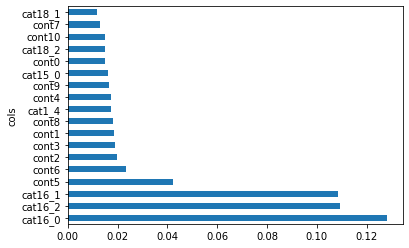

In [38]:
fi = rf_feat_importance(m_emb, emb_xs)
fi[:20].plot('cols', 'imp', 'barh', legend=False);

In [45]:
to_keep = fi[fi['imp']>.005].cols
len(to_keep)

26

Usually we experiment with the amount of columns to keep: we want as little features as possible without any meaningful drop in performance.

In [46]:
xs_filt = emb_xs[to_keep]
valid_xs_filt = emb_valid_xs[to_keep]

In [47]:
save_pickle('/content/valid_emb_filt', valid_xs_filt)
save_pickle('/content/train_emb_filt', xs_filt)

In [48]:
# this cell will take a couple minutes
m_filt = rf(xs_filt, to.train.y, min_samples_leaf=10)
auc(m_filt, xs_filt, to.train.y), auc(m_filt, valid_xs_filt, to.valid.y)

(0.841, 0.766)

## Inference

Let's try to apply our neural net and random forest that we trained to a test dataset in an ensemble.

In [49]:
test_df = pd.read_csv('/content/test.csv', low_memory=False)
test_df = test_df.drop('id', axis=1)
test_dl = dls.test_dl(test_df)
emb_test_xs = embed_features(learn, test_dl.dataset.xs)
filt_emb_test_xs = emb_test_xs[to_keep]

In [50]:
save_pickle('/content/emb_test_filt', test_df)

In [59]:
# NN inference
test_dl = dls.test_dl(test_df)
preds_nn,_ = learn.get_preds(dl=test_dl)
preds_nn = preds_nn.numpy().squeeze(1)

In [79]:
# RF inference
preds_rf = m_filt.predict_proba(filt_emb_test_xs)[:,1]

In [82]:
# simple ensemble
preds_ensemble = (preds_rf + preds.numpy().squeeze(1))/2
preds_ensemble

array([0.19655791, 0.43095821, 0.14695506, ..., 0.697493  , 0.24956956,
       0.4743461 ])

Congratulations! You have now obtained a more informative and flexible representation of your categorical data. Good luck with whatever you are planning to do with it; may your projects proceed ever smoothly.